<a href="https://colab.research.google.com/github/zia207/Deep-Neural-Network-Satellite-Image-Classification-in-Google-Colaboratory-iPython-Note-Book-/blob/master/hydrological_anlysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Surface Hydrological Analysis with WhiteboxTools in R

Zia Ahmed, University at Buffalo


Hydrological analysis involves studying how water flows and interacts within a geographical area. It integrates various spatial data, such as topography, land use, climate, and hydrological characteristics, to understand the movement of water through a landscape and its impact on water resources, ecosystems, and human activities. This type of analysis is essential for water resource management, flood prediction, environmental impact assessment, and more.

To prevent water from being stuck in a local depression as it travels downhill, you must first generate a filled DEM. Sometimes, the DEM may already be filled, making this step unnecessary. Next, the direction and accumulation of flows will then be calculated. While flow accumulation counts the number of cells that will drain into a particular cell, flow direction tells which neighboring cell water will migrate to. In order to define streams, you must first set a flow accumulation threshold un order to define streams.  You will identify stream links using this binary "stream/not stream" distinction and the flow direction grid. Finally, watersheds will be created as a raster file using the stream linkage and flow direction data, which will then be converted to polygons.


### Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314930 sha256=d5ccc605ddabb39dbc66c81be6fbcbae6450558f7ec5f9a94f06e858bc898901
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Packages

In [ ]:
%%R
install.packages(c('rgdal','maptools', 'raster', 'sf',
                   'rgeos' 'tidyverse', 'terra', 'devtools',
                   'classInt', 'RColorBrewer', 'spatialEco', 'gridExtra', 'rasterVis', 'tmap', 'stars', lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages("tmaptools", lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages("stars", lib='drive/My Drive/R/')

### Install whiteboxR package

In [ ]:

%%R
devtools::install_github("giswqs/whiteboxR", lib='drive/My Drive/R/')

### Installing WhiteboxTools
The quickest way to get started if you are on 64-bit Windows, Linux or MacOS architectures is to download and install the 'WhiteboxTools' binary.

A method install_whitebox() is provided to download a version of the binaries that corresponds to the wrapper functions available in the package.



In [ ]:
%%R
.libPaths('drive/My Drive/R')
library(whitebox)
whitebox::install_whitebox()

### Load other packges

In [45]:
%%R
.libPaths('drive/My Drive/R')
library (terra)
library(sf)
library (rgdal)
library(tidyverse)
library(classInt)
library(RColorBrewer)
library(raster)
library(gridExtra)
library(rasterVis)
library(tmap)
library(mapview)
library(tmaptools)
library(whitebox)

### Data

We will use 30 M SRTM elevation raster a area in Bandarban district, Bangladesh and the data can be found [here](https://github.com/zia207/r-colab/tree/main/Data/) for download.

In [6]:
%%R
# Input
dem <- "/content/drive/MyDrive/Data/Bangladesh/Raster/aoi_dtm_dem_BTM.tif"
dem

[1] "/content/drive/MyDrive/Data/Bangladesh/Raster/aoi_dtm_dem_BTM.tif"


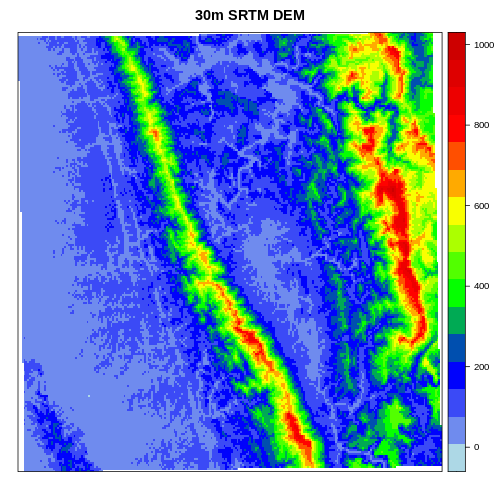

In [9]:
%%R -w 500 -h 500 -u px
# convert to raster object
dem_ras <- raster::raster(dem)
# create coustom color palette
rgb.palette <- colorRampPalette(c('lightblue',"blue","green","yellow","red", "red3"),
space = "rgb")
spplot(dem_ras,  main="30m SRTM DEM", col.regions=rgb.palette(100))

In [12]:
%%R
#Note: it does not work, only work in R-studio
tmap_mode("view")
dem_ras <- raster::raster(dem)
tm_shape(dem_ras)+
  tm_raster(style = "cont", palette = "PuOr", legend.show = TRUE)+
  tm_scale_bar()

### Hillshade

The **wbt_hillshade** tool performs a hillshade operation (also called shaded relief) on an input digital elevation model (DEM). The user must specify the name of the input DEM and the output hillshade image name.

In [13]:
%%R
wbt_hillshade(dem = "/content/drive/MyDrive/Data/Bangladesh/Raster/aoi_dtm_dem_BTM.tif",
              output = "/content/drive/MyDrive/Data/Bangladesh/Raster/hillshade.tif",
              azimuth = 115)

hillshade_ras <- raster("/content/drive/MyDrive/Data/Bangladesh/Raster/hillshade.tif")

hillshade - Elapsed Time (excluding I/O): 0.386s


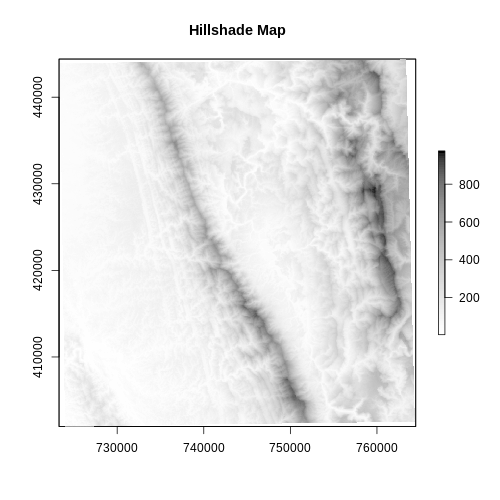

In [14]:
%%R -w 500 -h 500 -u px
plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='Hillshade Map')
plot(dem_ras, col = gray.colors(80, start =1, end = 0), add=TRUE)

### Processing DEM for Hydrology Analyses

Tools for hydrological anlayses are often designed to model follow of  water down the hillside based on the cell elevation in DEM. If there are no cells below a location along the flowpath, the algorithm terminates at the location. This location is known as the sink, pit or depression.

 **wbt_breach_depressions_least_cost()** breaches the depressions in a DEM using a least-cost pathway method. This tool can be employed to carry out a form of optimal depression breaching in order to prepare a Digital Elevation Model (DEM) for hydro-metrological analysis. This type of depression breaching is a popular alternative to the filling of depressions (FillDepressionions) and often provides a more cost-effective solution to the elimination of topographical depressions. For the purpose of this function, we will provide it with a maximum distance for searching for a site to breach (dist) and indicate whether to fill any remaining depressions after it has completed its task (fill).

In [15]:
%%R
wbt_breach_depressions_least_cost(
  dem = "/content/drive/MyDrive/Data/Bangladesh/Raster/aoi_dtm_dem_BTM.tif",
  output =  "content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/dem_breached.tif",
  dist = 5,
  fill = TRUE)

Error running WhiteboxTools (BreachDepressionsLeastCost)
  whitebox.exe_path: '/root/.local/share/R/whitebox/WBT/whitebox_tools'; File exists? TRUE
  Arguments: --run=BreachDepressionsLeastCost  --dem='/content/drive/MyDrive/Data/Bangladesh/Raster/aoi_dtm_dem_BTM.tif' --output='content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/dem_breached.tif' --dist=5 --min_dist --fill -v



* Welcome to BreachDepressionsLeastCost *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
Finding pits: 0%
Finding pits: 1%
Finding pits: 2%
Finding pits: 3%
Finding pits: 4%
Finding pits: 5%
Finding pits: 6%
Finding pits: 7%
Finding pits: 8%
Finding pits: 9%
Finding pits: 10%
Finding pits: 11%
Finding pits: 12%
Finding pits: 13%
Finding pits: 14%
Finding pits: 15%
Finding pits: 16%
Finding pits: 17%
Finding pits: 18%
Finding pits: 19%
Finding pits: 20%
Finding pits: 21%
Finding pits: 22%
Finding pits: 23%
Finding pits:

breach_depressions_least_cost - Elapsed Time: NA [did not run]


Then, because this algorithm can leave some remaining depressions, we wil use ***wbt_fill_depressions_wang_and_liu()** to clean up any remaining issue. This tool fills all of the depressions in a DEM using the Wang and Liu (2006) method. Depression breaching should be preferred in most cases.

This algorithm can still leave some depressions, so we'll use **wbt_fill_depressions_wang_and_liu()** tool to get rid of any remaining issues. This tool will fill all depressions in  DEM using Wang and Liu's (2006) mrthod.

In [16]:
%%R
wbt_fill_depressions_wang_and_liu(
  dem = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/dem_breached.tif",
  output = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/filled_dem_breached.tif"
)

fill_depressions_wang_and_liu - Elapsed Time (excluding I/O): 0.868s


### Visualize filled sinks and breached depressions

To see how fill and breach operations affect the DEM, we subtract the filled DEM from the original DEM. In areas where nothing changes, the values are zero. In areas that are filled, the values are positive, and in areas that are decreased in elevation to "breach" a depression, the values are negative. To see where things happened more clearly, we set all cells that are equal to zero to NA, and then plot them on our hillshade.

In [17]:
%%R
# convert to raster object
filled_breached = raster("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/filled_dem_breached.tif")
difference <- dem_ras - filled_breached
difference[difference == 0] <- NA

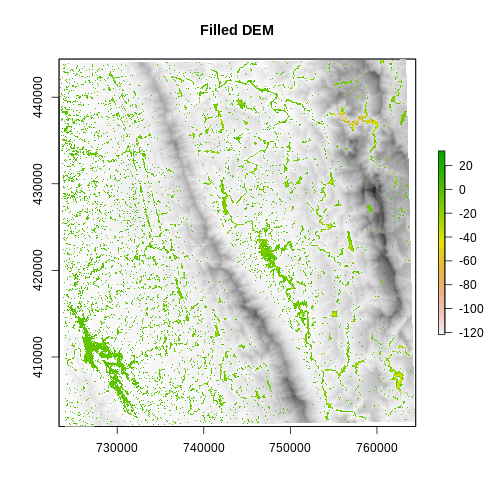

In [18]:
%%R -w 500 -h 500 -u px
plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='Filled DEM')
plot(dem_ras, col = gray.colors(80, start =1, end = 0), add=TRUE, legend=FALSE)
plot(difference, add=TRUE)

### D8 Flow Accumulation

D8 Flow accumulation tool generates the flow accumulation grid (contributing area) using FD8 algorithm(Freeman, 1991) sometimes known as FMFD. FD8 is an example of a multi-flow-direction method because the flow flowing into each grid cell is directed to each down slope neighbour, that is, flow divergence is allowed. In whitebox,  **wbt_d8_flow_accumulation()**  determines the direction water flow using filled_dem_breached raster.


In [19]:
%%R
wbt_d8_flow_accumulation(input = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/filled_dem_breached.tif",
                        output = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/D8FA.tif")


d8_flow_accumulation - Elapsed Time (excluding I/O): 0.195s


We are going to plot the log transformed D8 Flow Accumulation raster above the hillshade using 0.5 opacity using the alpha parameter of tm _raster. Using the hillshade for mapping allows us to visualize the flow accumulation in relation to the landscape. Plotting the log values allows us to see the differences in flow accumulation as the high values are much larger than the low values of a flow accumulation grid.

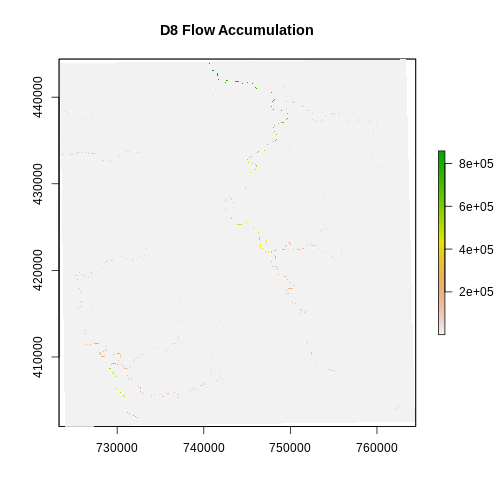

In [20]:
%%R -w 500 -h 500 -u px
# convert to raster object
d8 <- raster("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/D8FA.tif")
plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='D8 Flow Accumulation')
plot(dem_ras, col = gray.colors(80, start =1, end = 0), add=TRUE, legend=FALSE)
plot(d8, add=TRUE)

### Topographic Wetness Index (TWI)

The Topographic Wetness Index (TWI) is a terrain-based index used in hydrology and geomorphology to assess the potential for water accumulation and soil moisture retention in a landscape. It quantifies the local relative wetness of a terrain surface based on its topography. The TWI is particularly useful for identifying areas prone to saturation, runoff generation, and potential waterlogging.

The TWI is calculated using a combination of slope and contributing area (flow accumulation), which are derived from a digital elevation model (DEM). The basic idea is that areas with low slopes and high contributing areas are likely to retain more water due to reduced drainage capacity.

The formula for calculating the TWI often involves natural logarithms and can vary slightly depending on the context and research objectives. One common version of the formula is:

**TWI = ln(a / tanβ)**

Where:

-   **a**: Flow accumulation or contributing area

-   **β**: Slope angle in radians

Key points about the Topographic Wetness Index:

1.  **Interpretation:** Higher TWI values indicate areas with greater potential for wetness and water accumulation, while lower values correspond to drier areas.

2.  **Applications:** The TWI is used in various hydrological and environmental applications, including:

    -   Identifying areas prone to waterlogging, especially in agricultural fields or urban areas.

    -   Predicting locations of groundwater discharge or seepage.

    -   Assessing soil moisture conditions and potential for runoff.

    -   Supporting watershed management decisions, erosion control, and flood modeling.

3.  **Spatial Resolution:** The resolution of the DEM used to calculate the TWI affects the accuracy and detail of the results. Higher-resolution DEMs provide more accurate TWI values for smaller landscape features.

4.  **Limitations:** While the TWI provides valuable insights into landscape wetness, it may not consider certain localized factors (e.g., soil properties, vegetation cover) that can influence moisture patterns. Additionally, calibration and validation may be needed based on local conditions.

5.  **GIS Tools:** Geographic Information Systems (GIS) software often includes tools to calculate the TWI from DEMs. These tools help automate the calculation and allow for easy spatial analysis.

6.  **Comparative Analysis:** Comparing TWI values across different regions can help identify variations in landscape wetness potential, supporting hydrological and ecological studies.

Overall, the Topographic Wetness Index is a valuable tool for assessing terrain wetness potential and its implications for water movement, soil moisture, and ecosystem dynamics. It's commonly used in conjunction with other hydrological indices and data sources to provide a comprehensive understanding of the landscape's hydrological characteristics.

The wbt_wetness_index() function in whiteboxtool takes a raster of specific contributing area of flow accumulation and another of slope. We will need to create each of these first and then pass them to the function (since we didn't calculate specific contributing area when we used the flow accumulation algorithms above)

We will use **DInfFlowAccumulation** tool for generating a flow accumulation grid (i.e. contributing area) using the D-infinity algorithm (Tarboton, 1997). This algorithm is an examples of a multiple-flow-direction (MFD) method because the flow entering each grid cell is routed to one or two downslope neighbour, i.e. flow divergence is permitted.

In [21]:
%%R
#D-infinity -flow accumulation grid
wbt_d_inf_flow_accumulation(input = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/filled_dem_breached.tif",
                            output = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/DinfFAsca.tif",
                            out_type = "Specific Contributing Area")

d_inf_flow_accumulation - Elapsed Time (excluding I/O): 0.419s


In [22]:
%%R
#slope
wbt_slope(dem = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/filled_dem_breached.tif",
          output = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/dem_slope.tif",
          units = "degrees")

slope - Elapsed Time (excluding I/O): 0.294s


In [26]:
%%R
# TWI
wbt_wetness_index(sca =  "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/DinfFAsca.tif",
                  slope = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/dem_slope.tif",
                  output = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/TWI.tif")

wetness_index - Elapsed Time (excluding I/O): 0.100s


In [27]:
%%R
# covert twi to raster object
twi <- raster::raster("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/TWI.tif")
twi

class      : RasterLayer 
dimensions : 1378, 1448, 1995344  (nrow, ncol, ncell)
resolution : 28.3, 30.80041  (x, y)
extent     : 723394.3, 764372.7, 401963.6, 444406.6  (xmin, xmax, ymin, ymax)
crs        : +proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +datum=WGS84 +units=m +no_defs 
source     : TWI.tif 
names      : TWI 



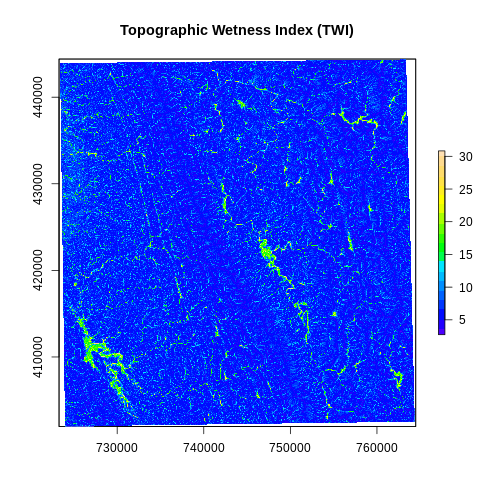

In [28]:
%%R -w 500 -h 500 -u px
plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='Topographic Wetness Index (TWI)')
plot(dem_ras, col = gray.colors(80, start =1, end = 0), add=TRUE, legend=FALSE)
plot(twi,col=topo.colors(20), add=TRUE)

### Downslope TWI

"Downslope TWI" likely refers to a modification or specific application of the Topographic Wetness Index (TWI) that takes into account the downslope direction of water flow. The TWI is calculated based on the combination of slope and flow accumulation, aiming to assess the potential for water accumulation and soil moisture retention in a landscape.

Adding "downslope" to the term imply that the TWI is being applied to consider the direction of water flow, which can influence where water accumulates and the wetness potential of different downslope areas. This modification could involve adjusting the TWI calculation to give more weight to areas with downslope flow convergence, which are likely to collect more water and have higher wetness potential.

We can replace the regular slope number in the TWI calculation with downslope index to calculate TWId or Downslope TWI.

TWI=Ln(As/tan(DownslopeIndex))


First, we will use **wbt_downslope_index()** to create downslope index raster from filled  DEM. The downslope index is a measure of the slope gradient between a grid cell and some downslope location (along the flowpath passing through the upslope grid cell) that represents a specified vertical drop (i.e. a potential head drop). The index has been shown to be useful for hydrological, geomorphological, and biogeochemical applications.

In [29]:
%%R
# downslope index raster
wbt_downslope_index(dem = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/filled_dem_breached.tif",
                    output = "/content/MyDrive/Data/Bangladesh/Raster/HYDRO/downslope_index.tif",
                    out_type = "tangent")

downslope_index - Elapsed Time (excluding I/O): 0.394s


In [30]:
%%R
# convert to raster object
# downslope index
downslope_index <- raster::raster("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/downslope_index.tif")
# D-infinity -flow accumulation grid
dinfFA <- raster::raster("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/DinfFAsca.tif")
## Downslop TWI
twid<-log(dinfFA / downslope_index)
#
twid[twid > 40] <- NA

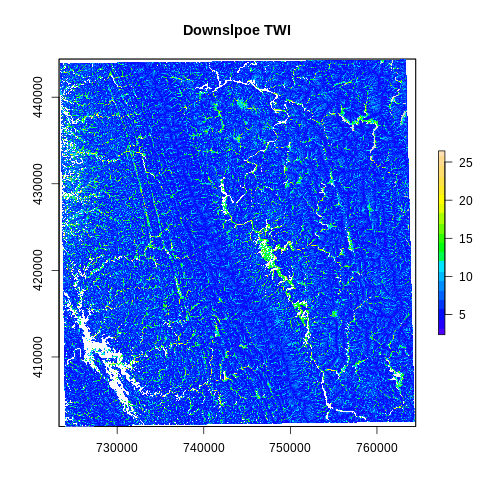

In [31]:
%%R -w 500 -h 500 -u px
plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='Downslpoe TWI')
plot(dem_ras, col = gray.colors(80, start =1, end = 0), add=TRUE, legend=FALSE)
plot(twid, col=topo.colors(20), add=TRUE)

### Stream Network

We can use flow accumulation grids to calculate and map the stream network inside a watershed. If we look at the flow accumulation grids, the highest values are in the streams. If we set the value for the flow accumulation to the highest point of the streamnetwork with consistent flow, then all the cells with a lower flow accumulation will be set to NO and we'll only have the cells in the stream. In some cases, we want the stream network to look more like a line, so we'll need to convert the raster to a vector format.

There are two functions available in Whitebox Tools that can be used to generate stream network.
**WbtExtractStreams()** returns a raster stream network based on the threshold flow accumulation parameter you provide. This function accepts a D8 stream accumulation grid as an input parameter.


In [32]:
%%R
wbt_extract_streams(flow_accum = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/D8FA.tif",
                    output = "content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/raster_streams.tif",
                    threshold = 1000)

extract_streams - Elapsed Time (excluding I/O): 0.21s


Then, **wbt_d8_pointer()** function return  a flow pointer grid from filled DEM using the simple D8 (O'Callaghan and Mark, 1984) algorithm.

In [33]:
%%R
wbt_d8_pointer(dem =  "/content/drive//MyDrive/Data/Bangladesh/Raster/HYDRO/filled_dem_breached.tif",
               output = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/D8pointer.tif")

d8_pointer - Elapsed Time (excluding I/O): 0.94s


Finally, **wbt_raster_streams_to_vector()** will take the output from  **from wbt_extract_streams()** and **wbt_d8_pointer**  and create  a shapefile of your stream network.

In [34]:
%%R
wbt_raster_streams_to_vector(streams = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/raster_streams.tif",
                             d8_pntr = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/D8pointer.tif",
                             output = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/streams.shp")

raster_streams_to_vector - Elapsed Time (excluding I/O): 0.23s


Let check the projection of stream lines

In [35]:
%%R
streams <- raster::shapefile("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/streams.shp")
streams

class       : SpatialLinesDataFrame 
features    : 1056 
extent      : 723436.8, 764103.9, 402040.6, 444360.4  (xmin, xmax, ymin, ymax)
crs         : +proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +datum=WGS84 +units=m +no_defs 
variables   : 2
names       :  FID, STRM_VAL 
min values  :    1,        1 
max values  : 1056,        1 


It looks like prj file is missing. We have to define the projection.

In [36]:
%%R
btm = CRS("+proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +datum=WGS84 +units=m +no_defs")
# define new projection
proj4string(streams) = CRS("+proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +datum=WGS84 +units=m +no_defs")

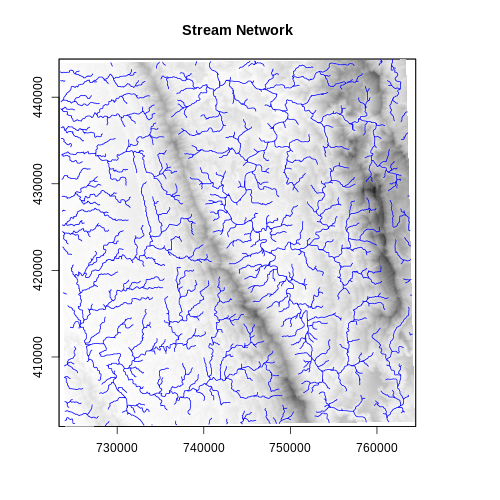

In [37]:
%%R -w 500 -h 500 -u px
d8 <- raster("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/D8FA.tif")
plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='Stream Network')
plot(dem_ras, col = gray.colors(80, start =1, end = 0), add=TRUE, legend=FALSE)
plot(streams, col="blue", add=TRUE)

### Watershed Delineation

Watershed delineation is a fundamental process in hydrology that involves identifying the boundaries of areas on the Earth's surface that contribute runoff water to a common outlet point, such as a stream, river, or lake. These areas are commonly referred to as watersheds or catchments. Watershed delineation plays a crucial role in understanding water movement, managing water resources, assessing flood risks, and making informed decisions about land use and environmental management.

Here's an overview of the watershed delineation process:

1.  **Digital Elevation Model (DEM):** The process begins with a digital elevation model (DEM), which is a digital representation of the Earth's surface elevation data. The DEM provides information about the topography of the landscape.

2.  **Flow Direction:** Using the DEM, the direction of water flow is determined for each cell or pixel on the landscape. This is typically done by identifying the steepest downhill path from each cell to its neighboring cells.

3.  **Flow Accumulation:** Flow accumulation calculates the number of cells that contribute flow to each cell in the landscape. Cells with higher flow accumulation values are indicative of areas that receive more runoff from their surroundings.

4.  **Thresholding:** A threshold is applied to the flow accumulation values to define the outlet point or points of the watershed. These outlets are typically located at stream or river junctions.

5.  **Watershed Delineation:** Starting from the defined outlet points, the watershed delineation process traces the upstream flow path based on the flow direction information. This results in the delineation of the entire watershed area that contributes flow to the chosen outlet points.

6.  **Boundary Definition:** The boundaries of the watershed are defined by connecting all the cells that contribute to the same outlet point. This forms the outline of the watershed area.

Watershed delineation is an essential tool for various applications, including:

-   **Hydrological Modeling:** Watershed boundaries are used as inputs in hydrological models to simulate water flow, runoff, and other hydrological processes.

-   **Flood Prediction:** Understanding watershed boundaries helps predict how water will accumulate and flow during heavy rainfall events.

-   **Water Resource Management:** Watershed delineation aids in assessing the availability and distribution of water resources within a specific region.

-   **Erosion and Sediment Transport:** Watersheds influence the movement of sediment and pollutants in water bodies, making watershed delineation important for erosion and sediment studies.

-   **Land Use Planning:** Knowledge of watershed boundaries helps in making informed decisions about land use, development, and conservation efforts.

Geographic Information Systems (GIS) software and hydrological modeling tools are commonly used for watershed delineation. These tools automate the process and allow for visualization of the delineated watersheds on maps.

Following steps need to be followed to delineate watershed using whitebox tools in R:


1. Fill or breaches the depressions in a DEM

2. Create flow accumulation and pointer grids

3. Extract stream network

4. Create pour points

5. Moves outlet points used to specify points of interest in a watershedding operation to the nearest stream cell.

6. Delineate watersheds

7. Convert watersheds to shapefiles


We have already done steps 1-3, in the following section will executes steps 4-7:

#### Create a pour point shape file

First, we will create a pour point shape file with 10 points.  The Lon and Lat information of these points were grabs from Google Earth.

In [40]:
%%R
# Create #a point dataframe
ppoints <- tribble(
          ~Lon, ~Lat,
          92.37401, 21.91499,
          92.34667, 21.9417,
          92.38052, 21.974,
		      92.39534, 22.0001,
		      92.42077, 21.89349,
		      92.18587, 21.85617,
		      92.19419, 21.99798,
		      92.34629, 22.06360,
		      92.43662, 21.81503,
		      92.22101, 21.76944
          )
# Create a spatial point data frame
ppointsSP_GCS <- SpatialPoints(ppoints,
         CRS("+proj=longlat +datum=WGS84 +no_defs "))
# Reprojection
btm = CRS("+proj=tmerc +lat_0=0 +lon_0=90 +k=0.9996 +x_0=500000 +y_0=-2000000 +datum=WGS84 +units=m +no_defs")
# define new projection
ppointsSP_BTM <- spTransform(ppointsSP_GCS, btm)
# write a shape file
shapefile(ppointsSP_BTM, filename = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/pourpoints_BTM.shp", overwrite = TRUE)

The **SnapPourPoints** tool can be used to move the location of vector pour points (i.e. outlets used in a Watershed operation)  to the location coincident with the highest flow accumulation value within a specified maximum distance.

In [41]:
%%R
wbt_jenson_snap_pour_points(pour_pts = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/pourpoints_BTM.shp",
                            streams = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/raster_streams.tif",
                            output = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/snappedpp.shp",
                            snap_dist = 1000)


jenson_snap_pour_points - Elapsed Time (excluding I/O): 0.0s


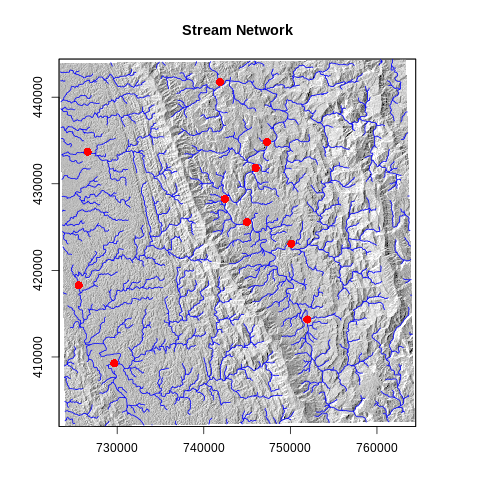

In [50]:
%%R -w 500 -h 500 -u px
raster_stream <- raster("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/raster_streams.tif")
pp <- shapefile("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/snappedpp.shp")

plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='Stream Network')
plot(raster_stream, col = gray.colors(80, start =1, end = 0), add=TRUE, legend=FALSE)
plot(streams, col="blue", add=TRUE)
plot(pp, col="red", cex=1.5, pch=16, add=TRUE)

#### Delineate watersheds

The  **wbt_watershed()** function takes as input a D8 pointer file (d8_pntr) and snapped pour points to create a raster where each watershed is populated with a unique value and all other cells are NA.


In [51]:
%%R
wbt_watershed(d8_pntr = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/D8pointer.tif",
              pour_pts = "/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/snappedpp.shp",
              output = "/content/MyDrive/Data/Bangladesh/Raster/HYDRO/aoi_watersheds.tif")

watershed - Elapsed Time (excluding I/O): 0.93s


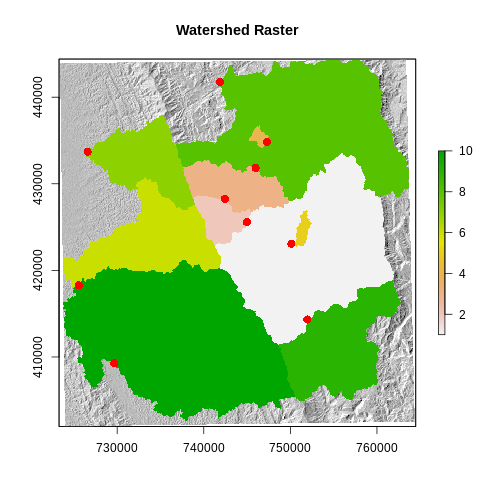

In [56]:
%%R -w 500 -h 500 -u px
ws <- raster("/content/drive/MyDrive/Data/Bangladesh/Raster/HYDRO/aoi_watersheds.tif")

plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='Watershed Raster')
plot(ws,  add=TRUE, legend=TRUE)
plot(pp, col="red", cex=1.5, pch=16, add=TRUE)

#### Convert watersheds raster to shapefiles

Using the [stars package](https://cran.r-project.org/web/packages/stars/index.html), we can convert watersheds raster to polygons for further analysis. First, we need to convert our watershed raster to an object that can be used by the stars package. Then, we need to use the **st_as_star()** function to convert the raster star object to a vector star object. Finally, we need to set the merge property to TRUE to tell **st_as_sf** to treat each cluster of cells that have the same value as our watersheds as its own feature.

In [58]:
%%R
library(stars)
ws_poly <- stars::st_as_stars(ws) %>% st_as_sf(merge = T)

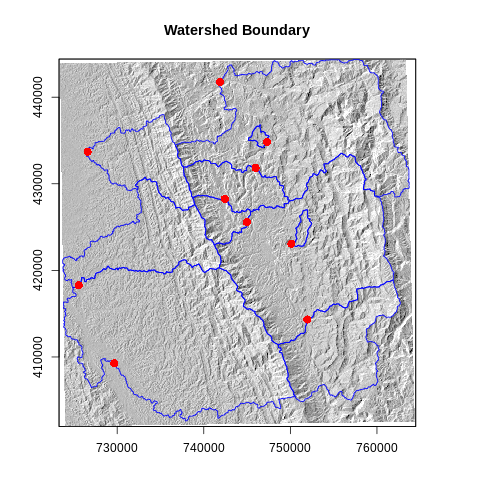

In [66]:
%%R -w 500 -h 500 -u px

plot(hillshade_ras,col = gray.colors(20, start =1, end = 0), legend=FALSE, main='Watershed Boundary')
plot(ws_poly,  add=TRUE, border="blue", col=NA)
plot(pp, col="red", cex=1.5, pch=16, add=TRUE)